<a href="https://colab.research.google.com/github/preetbhagat7/LovePreet-Portfolio/blob/main/dynsearching_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
import numpy as np
import pandas as pd
import json
import re
from collections import Counter
import matplotlib.pyplot as plt
from google.colab import files


In [69]:
# ---------------- FILE UPLOAD ----------------
print("\n📂 Upload your search dataset (CSV or Excel). Must contain a 'query' column.\n")
uploaded = files.upload()
data_file = list(uploaded.keys())[0]

if data_file.lower().endswith(".csv"):
    df = pd.read_csv(data_file)
else:
    df = pd.read_excel(data_file, engine="openpyxl")

df['query'] = df['query'].astype(str)

print("\n📂 Upload your CATEGORY MAP file (json / csv / xlsx / txt).\n")
uploaded_map = files.upload()
map_file = list(uploaded_map.keys())[0]


📂 Upload your search dataset (CSV or Excel). Must contain a 'query' column.



Saving Searches.xlsx to Searches (7).xlsx

📂 Upload your CATEGORY MAP file (json / csv / xlsx / txt).



Saving CATEGORY_MAP.json to CATEGORY_MAP (13).json


In [70]:
# -------- load category mapping --------
def load_category_map(file):
    if file.lower().endswith(".json"):
        return json.loads(open(file, "r").read())

    if file.lower().endswith(".csv"):
        df_map = pd.read_csv(file)
        return df_map.set_index("category")["keywords"].str.split("|").apply(lambda x: [i.strip().lower() for i in x]).to_dict()

    if file.lower().endswith(".xlsx"):
        df_map = pd.read_excel(file)
        return df_map.set_index("category")["keywords"].str.split("|").apply(lambda x: [i.strip().lower() for i in x]).to_dict()

    if file.lower().endswith(".txt"):
        data = open(file).read().strip().split("\n")
        cmap = {}
        for line in data:
            c, k = line.split(":")
            cmap[c.strip()] = [i.strip().lower() for i in k.split(",")]
        return cmap

    raise ValueError("Unsupported format. Use json/csv/xlsx/txt.")

CATEGORY_MAP = load_category_map(map_file)

In [71]:
# ---------------- Category reverse mapping ----------------
WORD_TO_CATEGORY = {}
for cat, words in CATEGORY_MAP.items():
    for w in words:
        WORD_TO_CATEGORY[w.lower()] = cat

In [72]:
# ---------------- CLEAN TEXT ----------------
all_text = " ".join(df['query']).lower()
cleaned = re.sub(r'[^a-z\s]', " ", all_text)
words = cleaned.split()
unique_words = sorted(set(words))


In [73]:
# ---------------- COUNT KEYWORD FREQUENCY ----------------
keyword_counts = {}
for kw in unique_words:
    count = df['query'].str.contains(rf"\b{kw}\b", case=False, na=False).sum()
    keyword_counts[kw] = count

# ---------------- CATEGORY TOTALS ----------------
category_totals = {}
for kw, count in keyword_counts.items():
    cat = WORD_TO_CATEGORY.get(kw)
    if cat:
        category_totals[cat] = category_totals.get(cat, 0) + count

In [74]:
# ------------------ Pie Chart ------------------
def show_pie_chart():
    labels = []
    sizes = []
    for cat, val in category_totals.items():
        if val > 0:
            labels.append(cat)
            sizes.append(val)

    plt.figure(figsize=(4, 4))
    plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140)
    plt.title("Category-wise Total Search Distribution")
    plt.show()


Enter keyword to search: toy

Keyword: toy
Total Searches (exact match): 3

Matching Queries:
  toy car for kids → 2
  baby toy → 1

Category: baby products
Total Searches in this Category: 37

 Category Search Distribution:



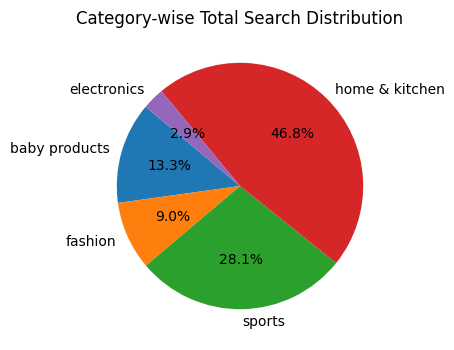

In [76]:
# ------------------ Keyword Lookup ------------------
def lookup_keyword():
    user_kw = input("\nEnter keyword to search: ").strip().lower()
    pattern = rf"\b{re.escape(user_kw)}\b"

    mask = df['query'].str.contains(pattern, case=False, na=False)

    if mask.sum() == 0:
        print("\nNever Searched Before\n")
        show_pie_chart()
        return

    matched_queries = df.loc[mask, 'query'].str.lower().tolist()
    query_counter = Counter(matched_queries)

    print(f"\nKeyword: {user_kw}")
    print(f"Total Searches (exact match): {sum(query_counter.values())}\n")

    print("Matching Queries:")
    for q, c in query_counter.items():
        print(f"  {q} → {c}")

    # category detection
    found_cat = None
    for cat, words in CATEGORY_MAP.items():
        if user_kw in words:
            found_cat = cat
            break

    if found_cat:
        print(f"\nCategory: {found_cat}")
        print(f"Total Searches in this Category: {category_totals.get(found_cat, 0)}")
    else:
        print("\nNo category found for this keyword.")

    print("\n Category Search Distribution:\n")
    show_pie_chart()

# run lookup
lookup_keyword()